In [1]:
%matplotlib inline
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as tfkl
import tensorflow_probability as tfp

import extended_tfp as extfp

tfd = tfp.distributions
tfpl = tfp.layers

# Version

In [2]:
assert tf.version.VERSION == '2.0.0-rc1'
assert tfp.__version__ == '0.8.0-rc0'

# Reproducibility

In [3]:
seed = 777
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Data

In [4]:
def transform_image(x):
    x = x[:, np.newaxis]
    x = x.astype(np.float32)
    x /= 255
    return x

In [5]:
def visualize_mnist(x, num_cols=5, image_size=2):
    x = x.squeeze()
    rank = len(x.shape)
    if rank == 2:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(x)
        ax.tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    if rank == 3:
        num_images = len(x)
        num_rows = np.ceil(num_images / num_cols).astype(int)
        figsize = (image_size * num_cols, image_size * num_rows)
        fig, axarr = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
        for img, ax in zip(x, axarr.flatten()):
            ax.imshow(img)
            ax.tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data('/tmp/mnist.npz')

x_train = transform_image(x_train)
x_test = transform_image(x_test)

x_valid = x_train[-10000:]
x_train = x_train[:-10000]

y_valid = y_train[-10000:]
y_train = y_train[:-10000]

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

input_shape = x_train.shape[1:]
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(50000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)


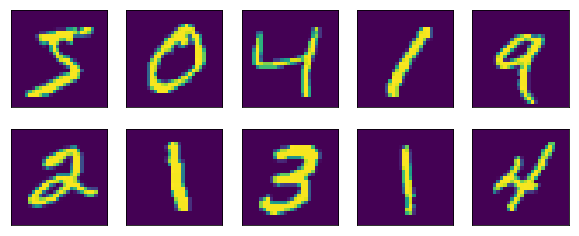

In [7]:
visualize_mnist(x_train[:10])

# Model Building

In [8]:
kl_weight = 1 / len(x_train)
print(f'KL weight: {kl_weight}')

KL weight: 2e-05


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    extfp.layers.Conv2DVariational(
        filters=32,
        kernel_size=(5, 5),
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight,
        activation='softplus'),
    extfp.layers.Conv2DVariational(
        filters=64,
        kernel_size=(5, 5),
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight,
        activation='softplus'),
    tf.keras.layers.MaxPooling2D(3, 3),
    tf.keras.layers.GlobalAveragePooling2D(),
    tfp.layers.DenseVariational(
        units=128,
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight,
        activation='softplus'),
    tfp.layers.DenseVariational(
        units=10,
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight),
    tfpl.OneHotCategorical(num_classes),
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_variational (Conv2DVa (None, 32, 24, 24)        2496      
_________________________________________________________________
conv2d_variational_1 (Conv2D (None, 64, 20, 20)        153792    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 6)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense_variational (DenseVari (None, 128)               24960     
_________________________________________________________________
dense_variational_1 (DenseVa (None, 10)                3870      
_________________________________________________________________
one_hot_categorical (OneHotC ((None, 10), (None, 10))  0

# Training

In [11]:
model.compile(loss=extfp.losses.negative_log_likelihood,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              metrics=['accuracy'])

In [12]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [13]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=500,
          shuffle=True,
          verbose=2,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/500
50000/50000 - 7s - loss: 261.3868 - accuracy: 0.1073 - val_loss: 5.8880 - val_accuracy: 0.1061
Epoch 2/500
50000/50000 - 3s - loss: 2.5218 - accuracy: 0.1086 - val_loss: 2.4753 - val_accuracy: 0.1080
Epoch 3/500
50000/50000 - 3s - loss: 2.4549 - accuracy: 0.1123 - val_loss: 2.4234 - val_accuracy: 0.1232
Epoch 4/500
50000/50000 - 3s - loss: 2.4363 - accuracy: 0.1337 - val_loss: 2.2944 - val_accuracy: 0.1608
Epoch 5/500
50000/50000 - 3s - loss: 2.2474 - accuracy: 0.1805 - val_loss: 2.2126 - val_accuracy: 0.1871
Epoch 6/500
50000/50000 - 3s - loss: 2.2147 - accuracy: 0.1917 - val_loss: 2.2076 - val_accuracy: 0.1968
Epoch 7/500
50000/50000 - 3s - loss: 2.1660 - accuracy: 0.1999 - val_loss: 2.1375 - val_accuracy: 0.2010
Epoch 8/500
50000/50000 - 3s - loss: 2.1539 - accuracy: 0.2069 - val_loss: 2.1208 - val_accuracy: 0.2070
Epoch 9/500
50000/50000 - 3s - loss: 2.1018 - accuracy: 0.2159 - val_loss: 2.0836 - val_accuracy: 0.2158
Epo

# Evaluation

In [14]:
def get_predictive_mean(model, x, num_monte_carlo=100):
    y_rv = model(x)
    y_samples = y_rv.sample(num_monte_carlo)
    return tf.argmax(tf.reduce_sum(y_samples, axis=0), axis=1)

In [15]:
y_pred_test = get_predictive_mean(model, x_test)

In [16]:
(y_pred_test.numpy() == y_test.argmax(axis=1)).mean()

0.9172

# Out-of-distribution

In [17]:
_, (x_fashion, y_fashion) = tf.keras.datasets.fashion_mnist.load_data()
x_fashion = transform_image(x_fashion)

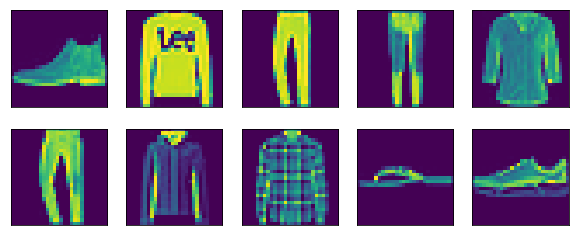

In [18]:
visualize_mnist(x_fashion[:10])

In [19]:
y_fashion_samples = np.stack([model.predict_on_batch(x_fashion).probs_parameter().numpy() for _ in range(100)])

In [20]:
y_test_samples = np.stack([model.predict_on_batch(x_test).probs_parameter().numpy() for _ in range(100)])

In [21]:
mnist_uncertainty = y_test_samples.std(axis=0).mean(axis=1)
fashion_uncertainty = y_fashion_samples.std(axis=0).mean(axis=1)

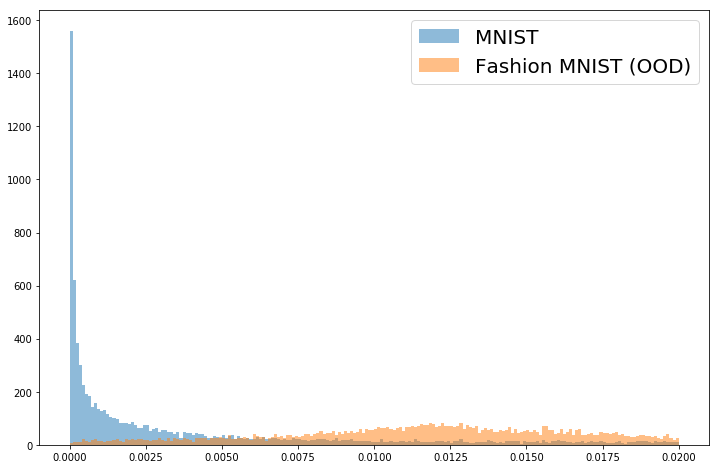

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(mnist_uncertainty, alpha=0.5, range=(0, 0.02), bins=200, label='MNIST')
ax.hist(fashion_uncertainty, alpha=0.5, range=(0, 0.02), bins=200, label='Fashion MNIST (OOD)')
ax.legend(fontsize=20)
# ax.set_yscale('log')